In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlite3
import pandas as pd
from scipy.stats import crystalball, chi2
from iminuit import Minuit

from iminuit.util import make_func_code
from iminuit import describe #, Minuit,
# Set custom color cycle
custom_colors = [    
    '#0081C8',  # Olynmpic Blue
    '#FCB131', # Olympic Yellow
    '#000000', # Olympic Black
    '#00A651',  # Olympic Green
    '#EE334E',  # Olynmpic Red
    '#F47835',  # Olympic Orange
    '#7C878E',  # Olympic Grey
    '#C8102E',  # Olympic Red
    '#EF3340',  # Olympic Red
    '#FFD662',  # Olympic Yellow
    '#00539C',  # Olympic Blue
]

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=custom_colors)


In [2]:
import sys
sys.path.append('/groups/icecube/simon/GNN/workspace/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax


In [6]:
pd.set_option('display.max_columns', None)

file_path = "/lustre/hpc/project/icecube/MuonGun_upgrade_full_detector_generation_volume_no_kde/filtered.db"

con = sqlite3.connect(file_path)

cur = con.cursor()

table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type='table'")]

print(table_list)

# Load data from CSV
df_truth = pd.read_sql_query("SELECT * FROM truth", con)
df_splits = pd.read_sql_query("SELECT * FROM SplitInIcePulsesSRT", con)
#create = "CREATE INDEX idx_event_no ON SplitInIcePulsesSRT(event_no);"
#cur.execute(create)
#query = "EXPLAIN QUERY PLAN SELECT * FROM SplitInIcePulsesSRT WHERE event_no = 1;"
#cur.execute(query)
#plan = cur.fetchall()
#for row in plan:
#    print(row)

con.close()
#df_tertiary = pd.read_sql_query("SELECT * FROM tertiary_particle", con)
#df = pd.read_sql_query("SELECT * FROM truth, SplitInIcePulsesSRT", con)
df_truth.head()


[('truth',), ('SplitInIcePulsesSRT',)]


KeyboardInterrupt: 

In [11]:
df_truth.head()

,index,energy,position_x,position_y,position_z,azimuth,zenith,pid,event_time,sim_type,interaction_type,elasticity,RunID,SubrunID,EventID,SubEventID,dbang_decay_length,track_length,stopped_muon,energy_track,energy_cascade,inelasticity,DeepCoreFilter_13,CascadeFilter_13,MuonFilter_13,OnlineL2Filter_17,L3_oscNext_bool,L4_oscNext_bool,L5_oscNext_bool,L6_oscNext_bool,L7_oscNext_bool,event_no
0,10,178.519744,428.092044,-80.622667,153.979952,1.872405,0.427249,13.0,1.306125e+17,NuGen,-1.0,-1.0,0.0,4.294967e+09,39.0,0.0,-1.0,709.827152,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10
1,12,343.640850,-256.279841,-308.596814,-123.891074,0.196701,1.137244,13.0,1.306125e+17,NuGen,-1.0,-1.0,0.0,4.294967e+09,50.0,0.0,-1.0,1179.901123,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12
2,18,121.182629,-36.023625,53.227071,409.567381,4.104174,0.655240,13.0,1.306125e+17,NuGen,-1.0,-1.0,0.0,4.294967e+09,77.0,0.0,-1.0,492.409886,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,18
3,34,239.157884,-212.532516,-434.380625,-241.785740,5.061323,0.624369,13.0,1.306125e+17,NuGen,-1.0,-1.0,0.0,4.294967e+09,190.0,0.0,-1.0,658.055023,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,34
4,38,252.461042,6.424822,-95.751358,-175.386139,4.449290,0.132864,13.0,1.306125e+17,NuGen,-1.0,-1.0,0.0,4.294967e+09,217.0,0.0,-1.0,984.059116,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,38


In [10]:
import time
import sqlite3

conn = sqlite3.connect("/groups/icecube/simon/GNN/workspace/filtered.db")
cursor = conn.cursor()

start_time = time.time()
cursor.execute("SELECT * FROM SplitInIcePulsesSRT WHERE event_no = 1")
results = cursor.fetchall()
end_time = time.time()

print(f"Query returned {len(results)} rows in {end_time - start_time:.4f} seconds.")


Query returned 0 rows in 0.0019 seconds.


In [4]:
df_splits = df_splits.sort_values(by=['event_no', 'dom_time'])

df_truth = df_truth.sort_values(by=['event_no'])
grouped_by_event = df_splits.groupby('event_no')
DOM_pos = list(zip(df_splits['dom_x'], df_splits['dom_y'], df_splits['dom_z']))
Dom_time = df_splits['dom_time'].values
charges_data = df_splits['charge'].values
Muon_end_pos = list(zip(df_truth['position_x'], df_truth['position_y'], df_truth['position_z'], df_truth['azimuth'], df_truth['zenith'], df_truth['track_length']))


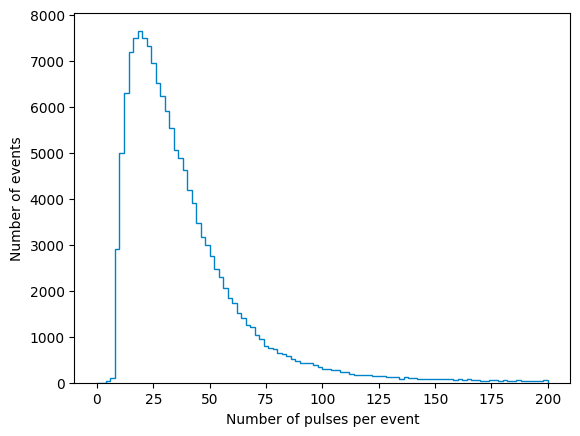

Mean number of pulses per event: 44.83717283721915
Median number of pulses per event: 31.0


In [5]:
amount_of_pulses = grouped_by_event.size()

plt.hist(amount_of_pulses, bins=100, range=(0, 200), histtype='step')
plt.xlabel('Number of pulses per event')
plt.ylabel('Number of events')

plt.show()

#Print the mean and median number of pulses per event
print('Mean number of pulses per event:', np.mean(amount_of_pulses))
print('Median number of pulses per event:', np.median(amount_of_pulses))


In [6]:
# data_dir = "/lustre/hpc/project/icecube/upgrade_sim/level4_queso/converted_sql/"
# db_path = f"{data_dir}/140029_cc.db"
# con2 = sqlite3.connect(db_path)
# cur2 = con2.cursor()
# table_list = [a for a in cur2.execute("SELECT name FROM sqlite_master WHERE type='table'")]
# df_truth2 = pd.read_sql_query("SELECT * FROM truth", con2)
# df_splits2 = pd.read_sql_query("SELECT * FROM SplitInIcePulses_dynedge_v2_Pulses", con2)


SyntaxError: invalid syntax (1478999980.py, line 8)

In [ ]:
amount_of_pulses2 = df_splits2.groupby('event_no').size()
plt.hist(amount_of_pulses2, bins=100, range=(0, 200), histtype='step')
plt.xlabel('Number of pulses per event')
plt.ylabel('Number of events')
plt.show()
print('Mean number of pulses per event:', np.mean(amount_of_pulses2))
print('Median number of pulses per event:', np.median(amount_of_pulses2))

In [9]:
# Constants
c = 0.299792458  # Speed of light in vacuum (m/ns)
n_ice = 1.34  # Refractive index of ice
v_photon = c / n_ice  # Speed of light in ice
v_muon = 0.98 * c  # Muon velocity (assumed to be close to the speed of light)
theta_c = np.arccos(1 / n_ice)  # Cherenkov angle in radians
ns_conversion = 1

In [13]:

def path(df):
    x_end = df['position_x']
    y_end = df['position_y']
    z_end = df['position_z']
    zenith = df['zenith']
    azimuth = df['azimuth']
    track_length = df['track_length']
    x_start = x_end + track_length*np.sin(zenith)*np.cos(azimuth)
    x_start = y_end + track_length*np.sin(zenith)*np.sin(azimuth)
    z_start = z_end + track_length*np.cos(zenith)
    return x_start, y_start, z_start, x_end, y_end, z_end

def reconstruct_photon_emission(muon_start, muon_end, dom_position):
    muon_start = np.array(muon_start)
    muon_end = np.array(muon_end)
    dom_position = np.array(dom_position)

    muon_dir = muon_end - muon_start
    muon_dir = muon_dir + 1e-10  # Avoid division by zero
    muon_dir_norm = muon_dir / np.linalg.norm(muon_dir)

    vec_dom = dom_position - muon_start
    projection_length = np.dot(vec_dom, muon_dir_norm)
    closest_point = muon_start + projection_length * muon_dir_norm

    distance_closest_to_dom = np.linalg.norm(dom_position - closest_point)
    perpendicular_distance = distance_closest_to_dom * np.tan(theta_c)
    emission_point = closest_point - perpendicular_distance * muon_dir_norm

    photon_distance = np.linalg.norm(emission_point - dom_position)
    photon_direction = dom_position - emission_point
    photon_zenith = np.arccos(photon_direction[2] / np.linalg.norm(photon_direction))
    photon_azimuth = np.arctan2(photon_direction[1], photon_direction[0])

    return emission_point, photon_distance, photon_azimuth, photon_zenith


In [14]:

def calculate_photon_distance(P_DOM, P1, P2, theta_Cher):
    """
    Calculate the distance from the Cherenkov emission point to the DOM.

    Parameters:
    - P_DOM: Position of the DOM (3D vector).
    - P1: Start point of the muon (3D vector).
    - P2: End point of the muon (3D vector).
    - theta_Cher: Cherenkov angle in radians.

    Returns:
    - photon_distance: Distance from P_Cherenkov to P_DOM.
    - P_Cherenkov: Position of the Cherenkov emission point.
    """
    # Calculate the muon track direction vector and its length
    muon_dir = P2 - P1
    muon_length = np.linalg.norm(muon_dir)
    
    # Normalize the muon direction vector
    muon_dir_unit = muon_dir / muon_length
    
    # Calculate vector from P2 to P_DOM and projection length `n` on muon direction
    vec_P1_DOM = P1- P_DOM
    projection_length = np.dot(vec_P1_DOM, muon_dir_unit)  # Projection of P2->DOM on muon_dir
    
    # Calculate P_DOCA using the normalized projection
    P_DOCA = P1 - projection_length * muon_dir_unit  # Closest point on the track
    
    # Distance from P_DOCA to P_DOM
    d_DOCA = np.linalg.norm(P_DOM - P_DOCA)
    
    # Distance from P_DOCA to P_Cherenkov
    distance_to_P_Cherenkov = d_DOCA * np.tan(theta_Cher)
    
    # Calculate `r` in terms of muon direction units
    r = distance_to_P_Cherenkov / muon_length
    
    # Calculate P_Cherenkov position
    P_Cherenkov = P_DOCA - r * muon_dir
    
    # Photon distance from P_Cherenkov to P_DOM
    photon_distance = np.linalg.norm(P_DOM - P_Cherenkov)
    
    return photon_distance, P_Cherenkov


In [21]:
import numpy as np

# Constants
c = 0.299792458  # Speed of light in vacuum (m/ns)
n_ice = 1.34  # Refractive index of ice
v_photon = c / n_ice  # Speed of light in ice
v_muon = 0.98 * c  # Muon velocity (assumed to be close to the speed of light)
theta_c = np.arccos(1 / n_ice)  # Cherenkov angle in radians

# Function to compute DOM timing based on input data structure
def calculate_dom_timing_optimized(grouped_by_event, Muon_end_pos):
    dom_timings = []
    short_time = []
    # Precompute muon start points and directions
    muon_end_array = np.array(Muon_end_pos)[:, :3]  # Extract x, y, z only
    azimuths = np.array(Muon_end_pos)[:, 3]
    zeniths = np.array(Muon_end_pos)[:, 4]
    lengths = np.array(Muon_end_pos)[:, 5]

    # Precompute muon endpoints
    x_start = muon_end_array[:, 0] + lengths * np.sin(zeniths) * np.cos(azimuths)
    y_start = muon_end_array[:, 1] + lengths * np.sin(zeniths) * np.sin(azimuths)
    z_start = muon_end_array[:, 2] + lengths * np.cos(zeniths)
    muon_start_array = np.vstack((x_start, y_start, z_start)).T

    # Iterate over each muon track (each event)
    for i, (muon_start, muon_end) in enumerate(zip(muon_start_array, muon_end_array)):
        # Get the DOM data for this specific event
        event_id = i  # Assuming event indexing aligns with Muon_start_pos
        if event_id not in grouped_by_event.groups:
            continue  # Skip if the event is not in the DOM data

        event_data = grouped_by_event.get_group(event_id)
        dom_positions = np.array(list(zip(event_data['dom_x'], event_data['dom_y'], event_data['dom_z'])))
        dom_times = event_data['dom_time'].values  # DOM times for this event
        
        # Vectorized calculation for all DOMs at once
        vec_dom = dom_positions - muon_start  # Vector from muon start to each DOM
        muon_dir = muon_end - muon_start
        muon_dir_norm_val = np.linalg.norm(muon_dir)  # Norm of muon direction 
        
        if muon_dir_norm_val == 0:
            continue 
        muon_dir_norm = muon_dir / muon_dir_norm_val  # Normalize direction
        
        # Project DOM vector onto the muon direction
        projection_lengths = np.dot(vec_dom, muon_dir_norm)
        closest_points = muon_start + np.outer(projection_lengths, muon_dir_norm)

        # Calculate distances between closest point on muon track and DOMs
        distances_closest_to_dom = np.linalg.norm(dom_positions - closest_points, axis=1)

        # Calculate photon emission points
        #perpendicular_distances = distances_closest_to_dom * np.tan(theta_c)
        #emission_points = closest_points - np.outer(perpendicular_distances, muon_dir_norm)

        # Calculate photon travel distances and times
       # shortest_dist = np.linalg.norm(dom_positions - emission_points, axis=1)
        
        # photon_distances, P_cherenkov = np.array([calculate_photon_distance(dom_pos, muon_start, muon_end, theta_c) 
        #                      for dom_pos in dom_positions])
        
        # Initialize lists to store distances and Cherenkov points
        photon_distances = []
        P_cherenkov_points = []

        # Loop through each DOM position
        for dom_pos in dom_positions:
            dist, P_cher = calculate_photon_distance(dom_pos, muon_start, muon_end, theta_c)
            photon_distances.append(dist)
            P_cherenkov_points.append(P_cher)

        # Convert to numpy arrays if necessary
        photon_distances = np.array(photon_distances)
        P_cherenkov = np.array(P_cherenkov_points)

        t_photon = photon_distances / v_photon
        shortest_t = distances_closest_to_dom / v_photon
        # Calculate muon travel time from point A (end of muon track) to emission point
        d_A_Cher = np.linalg.norm(muon_end - P_cherenkov, axis=1)
       # d_A_short = np.linalg.norm(muon_end - closest_points, axis=1)
        t_muon = d_A_Cher / v_muon

        # Calculate the DOM signal time based on photon travel time and muon travel time
        t_dom = dom_times - t_photon*n_ice + t_muon
        t_dom_short = dom_times - shortest_t*n_ice + t_muon
        dom_timings.append(t_dom)
        short_time.append(t_dom_short)

    return np.concatenate(dom_timings), np.concatenate(short_time)

# Example usage:
# Assuming df_splits has been grouped by 'event_no'
grouped_by_event = df_splits.groupby('event_no')

# Call the function
dom_timings, short_dist_time = calculate_dom_timing_optimized(grouped_by_event, Muon_end_pos)


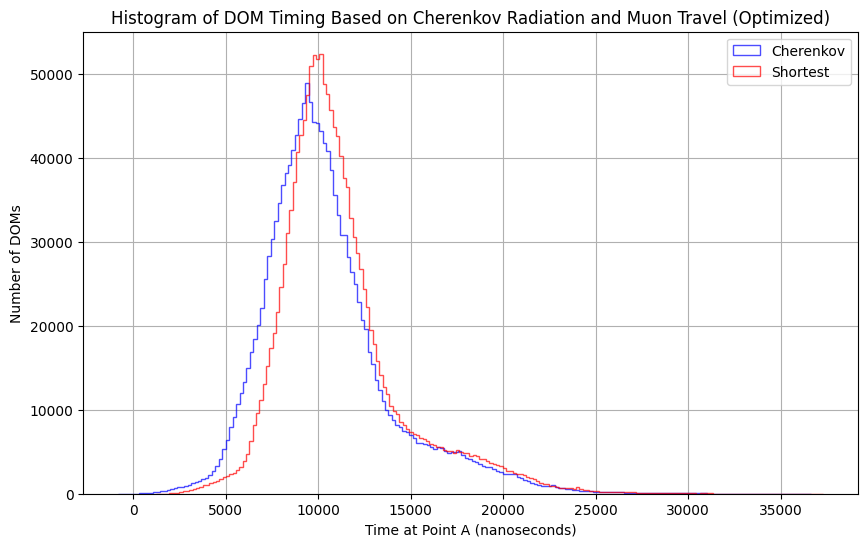

In [24]:
# Call the calculate_dom_timing_optimized function with your data
#dom_timings2= calculate_dom_timing_optimized(DOM_pos, Dom_time, Muon_start_pos, Muon_time)

# Plot the DOM timings as a histogram
plt.figure(figsize=(10, 6))
plt.hist(dom_timings, bins=200, color='blue', histtype = 'step', alpha=0.7, label='Cherenkov')
plt.hist(short_dist_time, bins=200, color='red', histtype = 'step', alpha=0.7, label='Shortest')
plt.xlabel('Time at Point A (nanoseconds)')
plt.ylabel('Number of DOMs')
plt.title('Histogram of DOM Timing Based on Cherenkov Radiation and Muon Travel (Optimized)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Function to shift timings so that each event signal has the same mean (chosen as zero)
def shift_dom_timing(dom_timings, window_ns):
    window = window_ns  # Convert the 400 ns window into seconds
    
    # Remove NaN values from dom_timings
    dom_timings = dom_timings[~np.isnan(dom_timings)]

    # Calculate the median of the DOM timings
    median_timing = np.median(dom_timings)

    # Identify t_A values within the 400 ns window around the median
    timings_in_window = dom_timings[(dom_timings >= median_timing - window) & (dom_timings <= median_timing + window)]

    # Calculate the mean of the values within the window
    mean_timing = np.mean(timings_in_window)

    # Shift all timings so the mean is zero
    shifted_timings = dom_timings - mean_timing

    return shifted_timings, median_timing, mean_timing, window

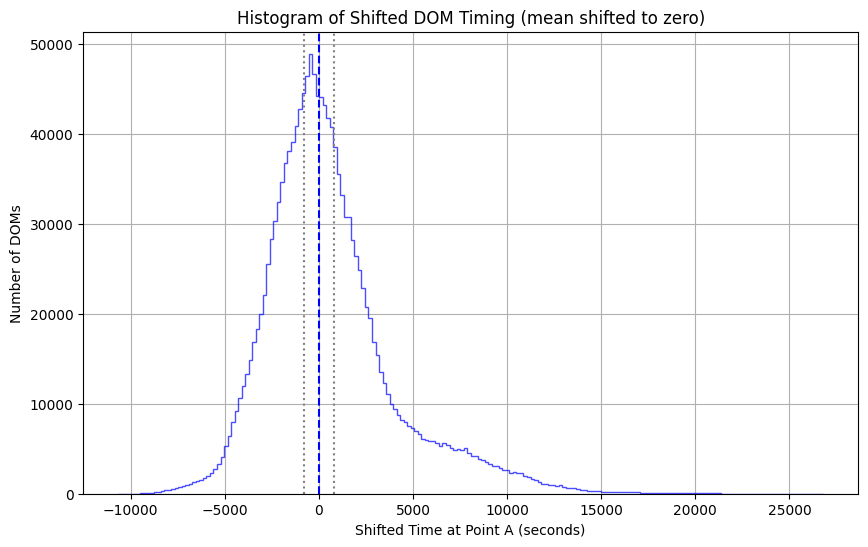

In [27]:
# Shift the DOM timings so the signal mean is zero
shifted_dom_timings, median_timing, mean_timing, window = shift_dom_timing(dom_timings, window_ns=800)

# Plot the shifted DOM timings as a histogram
plt.figure(figsize=(10, 6))
plt.hist(shifted_dom_timings, bins=200, color='blue', alpha=0.7, histtype='step')

plt.axvline(median_timing - mean_timing, color='blue', linestyle='--', label='Median Shifted to Zero')
plt.axvline(median_timing - mean_timing - window, color='gray', linestyle=':', label='Timing Window')
plt.axvline(median_timing - mean_timing + window, color='gray', linestyle=':')
plt.xlabel('Shifted Time at Point A (seconds)')
plt.ylabel('Number of DOMs')
plt.title('Histogram of Shifted DOM Timing (mean shifted to zero)')
plt.grid(True)
plt.show()

Mean total number of pulses per event: 44.83717283721915
Median total number of pulses per event: 31.0
Mean number of pulses in time window per event: 26.286030910101356
Median number of pulses in time window per event: 15.0


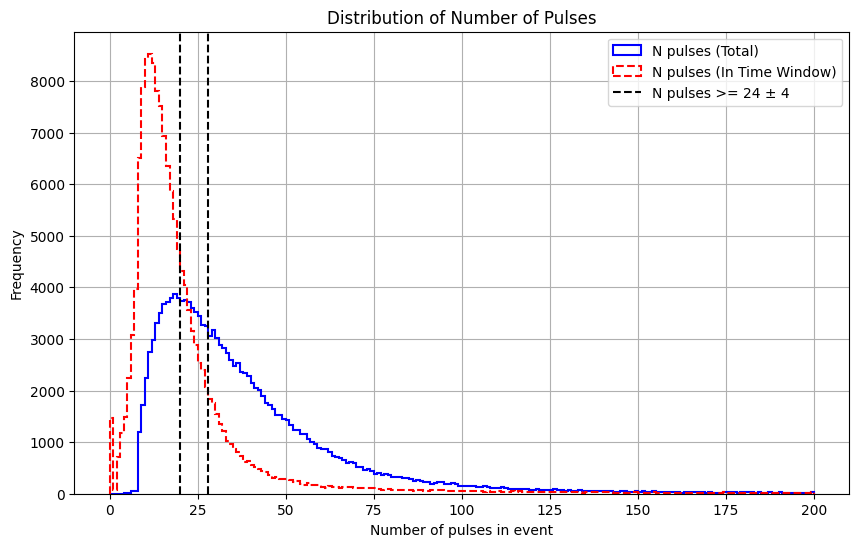

In [29]:
def calculate_pulse_counts(dom_timings, window_ns=800):
    total_pulses = len(dom_timings)
    
    # Remove NaN values from dom_timings
    dom_timings = dom_timings[~np.isnan(dom_timings)]

    if len(dom_timings) == 0:
        return total_pulses, 0

    # Calculate the median of the DOM timings
    median_timing = np.median(dom_timings)

    # Identify pulses (DOMs) within the 400 ns window around the median
    pulses_in_window = dom_timings[(dom_timings >= median_timing - window) & (dom_timings <= median_timing + window)]
    
    # Number of pulses in time window
    pulses_in_window_count = len(pulses_in_window)
    return total_pulses, pulses_in_window_count

total_pulses_list = []
pulses_in_window_list = []

# Iterate through all events in the dataset
for event_no, group in grouped_by_event:
    dom_timings = group['dom_time'].values

    total_pulses, pulses_in_window = calculate_pulse_counts(dom_timings)
    
    total_pulses_list.append(total_pulses)
    pulses_in_window_list.append(pulses_in_window)

# Convert lists to NumPy arrays for easier calculations
total_pulses_array = np.array(total_pulses_list)
pulses_in_window_array = np.array(pulses_in_window_list)

# Calculate the mean and median for total pulses and pulses in the time window
mean_total_pulses = np.mean(total_pulses_array)
median_total_pulses = np.median(total_pulses_array)

mean_pulses_in_window = np.mean(pulses_in_window_array)
median_pulses_in_window = np.median(pulses_in_window_array)

# Print the results
print(f"Mean total number of pulses per event: {mean_total_pulses}")
print(f"Median total number of pulses per event: {median_total_pulses}")

print(f"Mean number of pulses in time window per event: {mean_pulses_in_window}")
print(f"Median number of pulses in time window per event: {median_pulses_in_window}")

# Plot the histograms
plt.figure(figsize=(10, 6))

# Total number of pulses
plt.hist(total_pulses_list, bins=200, range=(0,200), histtype='step', color='blue', label='N pulses (Total)', linewidth=1.5)

# Number of pulses in the time window
plt.hist(pulses_in_window_list, bins=200, range=(0,200), histtype='step', color='red', linestyle='--', label='N pulses (In Time Window)', linewidth=1.5)

# Add vertical lines for the pulse count requirement (15 ± 3)
plt.axvline(24 - 4, color='black', linestyle='--', label='N pulses >= 24 ± 4')
plt.axvline(24 + 4, color='black', linestyle='--')

plt.xlabel('Number of pulses in event')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Pulses')

plt.legend()
plt.grid(True)
plt.show()


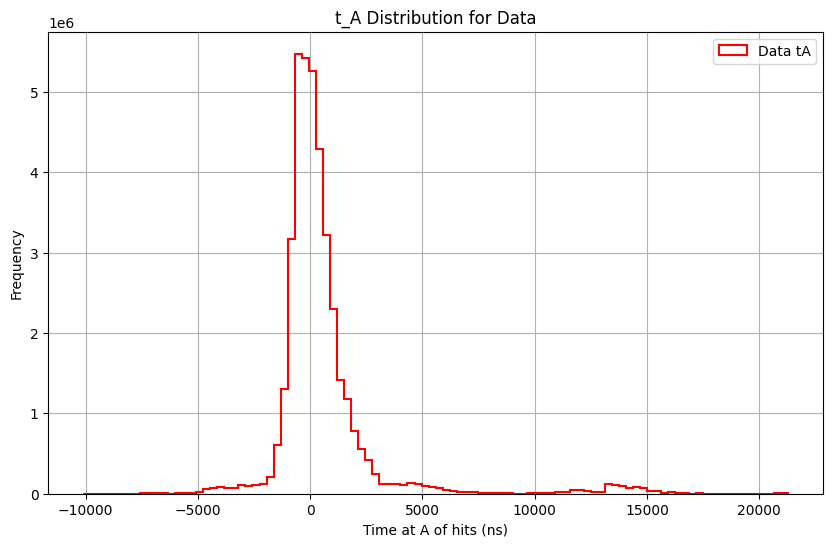

In [15]:
# Constants
ns_conversion = 1  # Conversion factor for nanoseconds to seconds

# Function to shift DOM timings for t_A calculation
def shift_dom_timing_next(dom_timings, window_ns=1000):
    # Convert the 400 ns window into seconds
    window = window_ns 
    # Remove NaN values from dom_timings
    dom_timings = dom_timings[~np.isnan(dom_timings)]

    # Calculate the median of the DOM timings
    if len(dom_timings) == 0:
        return np.array([])

    median_timing = np.median(dom_timings)

    # Identify t_A values within the 400 ns window around the median
    timings_in_window = dom_timings[(dom_timings >= median_timing - window) & (dom_timings <= median_timing + window)]

    # Calculate the mean of the values within the window
    mean_timing = np.mean(timings_in_window) if len(timings_in_window) > 0 else 0

    # Shift all timings so the mean is zero
    shifted_timings = dom_timings - mean_timing

    return shifted_timings

# Function to compute t_A for all viable events
def calculate_ta_for_events(viable_dom_times):
    ta_values = []

    # Iterate through each viable event
    for dom_timings in viable_dom_times:
        dom_timings, _ = calculate_dom_timing_optimized(grouped_by_event, Muon_start_pos, Muon_time)
        shifted_ta = shift_dom_timing_next(dom_timings)
        if len(shifted_ta) > 0:
            ta_values.extend(shifted_ta)  # Collect all t_A values
    
    return np.array(ta_values)

# Filter the viable DOM timings from df_splits based on the number of pulses (32 ± 6.4)
# Assuming the data is sorted by event_no and you are grouping them by event

# Group the data by 'event_no'
grouped_by_event = df_splits.groupby('event_no')

# Threshold for viable events (32 ± 6.4 pulses)
min_pulses = 24 - 4


# Prepare a list to store viable DOM timings for t_A calculation
viable_dom_times_data = []

# Function to calculate number of pulses in an event and apply pulse filter
def calculate_pulse_counts(dom_timings, window_ns=1000):
    total_pulses = len(dom_timings)
    
    # Convert window to seconds (ns to s)
    window = window_ns  

    # Remove NaN values from dom_timings
    dom_timings = dom_timings[~np.isnan(dom_timings)]

    if len(dom_timings) == 0:
        return total_pulses, 0

    # Calculate the median of the DOM timings
    median_timing = np.median(dom_timings)

    # Identify pulses (DOMs) within the 400 ns window around the median
    pulses_in_window = dom_timings[(dom_timings >= median_timing - window) & (dom_timings <= median_timing + window)]
    
    # Number of pulses in time window
    pulses_in_window_count = len(pulses_in_window)
    
    return total_pulses, pulses_in_window_count

# Iterate through each group (i.e., each event)
for event_no, group in grouped_by_event:
    # Extract the DOM timings for this event
    dom_timings = group['dom_time'].values
    
    # Calculate the total pulses and pulses in the time window
    total_pulses, pulses_in_window = calculate_pulse_counts(dom_timings)
    
    # Apply the mask for viable events, which is at least 31 pulses
    if total_pulses >= min_pulses:
        viable_dom_times_data.append(dom_timings)

# Calculate t_A values for the viable data events
ta_values_data = calculate_ta_for_events(viable_dom_times_data)

# Plot the histogram for the data's t_A values
plt.figure(figsize=(10, 6))

# Histogram for Data t_A values
plt.hist(ta_values_data, bins=100, histtype='step', color='red', label='Data tA', linewidth=1.5)  # Convert back to ns

# Formatting the plot
plt.xlabel('Time at A of hits (ns)')
plt.ylabel('Frequency')
plt.title('t_A Distribution for Data')
plt.legend()
plt.grid(True)
plt.show()


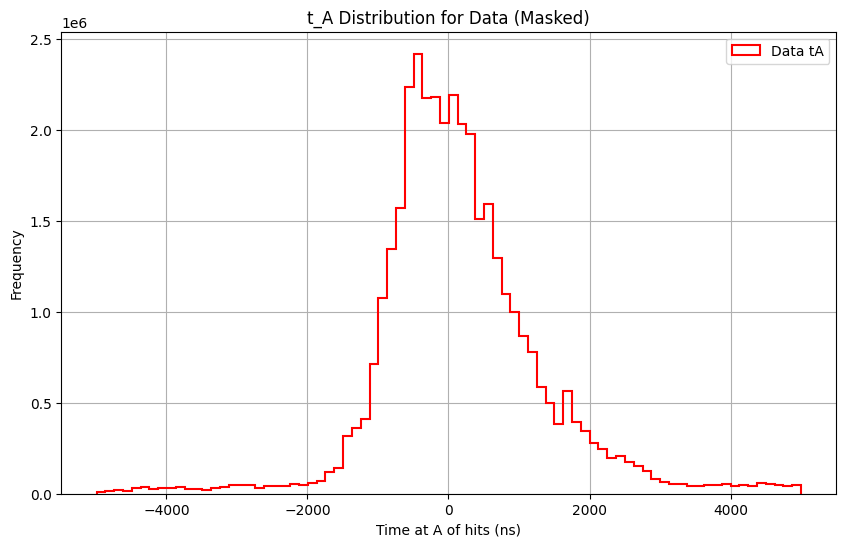

In [16]:
# Generate the same plot, but limit the data to -1000 to 1500 ns
mask = (ta_values_data >= -5000) & (ta_values_data <= 5000)
ta_values_data_masked = ta_values_data[mask]

# Plot the histogram for the masked data's t_A values
plt.figure(figsize=(10, 6))

# Histogram for Data t_A values
plt.hist(ta_values_data_masked, bins=80, histtype='step', color='red', label='Data tA', linewidth=1.5)  # Convert back

# Formatting the plot
plt.xlabel('Time at A of hits (ns)')
plt.ylabel('Frequency')
plt.title('t_A Distribution for Data (Masked)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3226054/3342229590.py:34: FutureWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


E VariableMetricBuilder Initial matrix not pos.def.


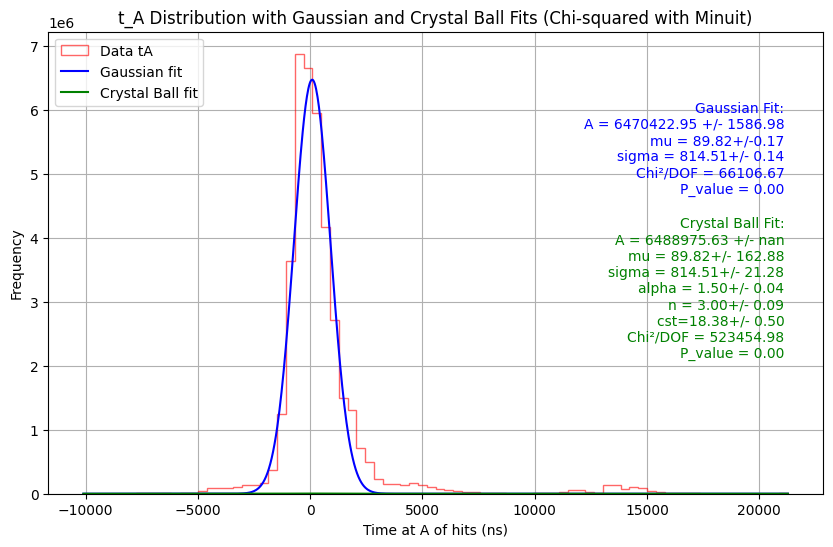

Gaussian fit parameters: A = 6470422.951800361, mu = 89.8198703330143, sigma = 814.5142170058614


In [17]:
def set_var_if_None(var, x):
    if var is not None:
        return np.array(var)
    else: 
        return np.ones_like(x)
    
def compute_f(f, x, *par):
    
    try:
        return f(x, *par)
    except ValueError:
        return np.array([f(xi, *par) for xi in x])


class Chi2Regression:  # override the class with a better one
        
    def __init__(self, f, x, y, sy=None, weights=None, bound=None):
        
        if bound is not None:
            x = np.array(x)
            y = np.array(y)
            sy = np.array(sy)
            mask = (x >= bound[0]) & (x <= bound[1])
            x  = x[mask]
            y  = y[mask]
            sy = sy[mask]

        self.f = f  # model predicts y for given x
        self.x = np.array(x)
        self.y = np.array(y)
        
        self.sy = set_var_if_None(sy, self.x)
        self.weights = set_var_if_None(weights, self.x)
        self.func_code = make_func_code(describe(self.f)[1:])

        
    def __call__(self, *par):  # par are a variable number of model parameters
        
        # compute the function value
        f = compute_f(self.f, self.x, *par)
        
        # compute the chi2-value
        chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)
        
        return chi2

# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Define Crystal Ball function with free alpha and n
def crystal_ball(x, alpha, n, mu, sigma, A, cst):
    return A * crystalball.pdf(-x, beta=alpha, m=n, loc=mu, scale=sigma) + cst

def func_CBpol0(x, N, mu, sigma, beta, m, cst) : # Troels CB function
    xmax = np.max(x)
    xmin = np.min(x)
    Nbins = 80
    binwidth_gauss = (xmax-xmin)/Nbins
    return N * binwidth_gauss * crystalball.pdf(-x, beta, m, loc=mu, scale=sigma) + cst

# Generate the histogram data from the t_A values
ta_values_ns = ta_values_data  # Assuming ta_values_data is already in nanoseconds
bins = 80
hist, bin_edges = np.histogram(ta_values_ns, bins=bins)

# Midpoints of bins for fitting
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Set uncertainties (e.g., sqrt of counts) and weights
sy = np.sqrt(hist + 1)  # Set uncertainty to sqrt(counts) to avoid zero uncertainties
weights = np.ones_like(hist)  # You can customize weights if needed

# Step 1: Perform Chi2 regression for Gaussian
chi2_gauss = Chi2Regression(gaussian, bin_centers, hist, sy=sy, weights=weights)
m_gauss = Minuit(chi2_gauss, A=np.max(hist), mu=np.mean(ta_values_ns), sigma=np.std(ta_values_ns))
m_gauss.limits['A'] = (0, None)  # Set lower bound for amplitude
m_gauss.limits['sigma'] = (0, None)  # Set lower bound for sigma
m_gauss.errordef = 1
m_gauss.tol = 0.001
m_gauss.migrad()  # Perform the minimization

# Step 2: Perform Chi2 regression for Crystal Ball with free alpha and n
chi2_cb = Chi2Regression(crystal_ball, bin_centers, hist, sy=sy, weights=weights)
m_cb = Minuit(chi2_cb, alpha=1.5, n=3.0, mu=m_gauss.values['mu'], sigma=m_gauss.values['sigma'], A=m_gauss.values['A'], cst=0)
m_cb.limits['alpha'] = (0.1, 10)  # Reasonable bounds for alpha
m_cb.limits['n'] = (1, 10)  # Reasonable bounds for n
m_cb.limits['sigma'] = (10, None)  # Set a lower bound for sigma to avoid collapsing
m_cb.limits['A'] = (0, None)  # Set lower bound for amplitude
m_cb.limits['cst'] = (0, None)  # Set lower bound for constant term
m_cb.errordef = 1
m_cb.tol = 0.001
m_cb.migrad()  # Perform the minimization

chi2_CBpol0 = Chi2Regression(func_CBpol0, bin_centers, hist, sy=sy, weights=weights)
m_CBpol0 = Minuit(chi2_CBpol0, N=np.max(hist), mu=np.mean(ta_values_ns), sigma=np.std(ta_values_ns), beta=1.5, m=3.0, cst=0)
m_CBpol0.limits['N'] = (0, None)  # Set lower bound for amplitude
m_CBpol0.limits['sigma'] = (0, None)  # Set lower bound for sigma
m_CBpol0.limits['beta'] = (0.1, 10)  # Reasonable bounds for alpha
m_CBpol0.limits['m'] = (1, 10)  # Reasonable bounds for n
m_CBpol0.limits['cst'] = (0, None)  # Set lower bound for constant term
m_CBpol0.errordef = 1
m_CBpol0.migrad()  # Perform the minimization

# Compute chi-squared and degrees of freedom (DOF)
chi2_gauss_val = m_gauss.fval
dof_gauss = len(hist) - len(m_gauss.parameters)
red_chi2_gauss = chi2_gauss_val / dof_gauss
p_value_gauss = chi2.sf(chi2_gauss_val, dof_gauss)
# Find the uncertainties on the parameters


chi2_cb_val = m_cb.fval
dof_cb = len(hist) - len(m_cb.parameters)
red_chi2_cb = chi2_cb_val / dof_cb
p_value_cb = chi2.sf(chi2_cb_val, dof_cb)

chi2_CBpol0_val = m_CBpol0.fval
dof_CBpol0 = len(hist) - len(m_CBpol0.parameters)
red_chi2_CBpol0 = chi2_CBpol0_val / dof_CBpol0
p_value_CBpol0 = chi2.sf(chi2_CBpol0_val, dof_CBpol0)


# Plot the histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(ta_values_ns, bins=bins, alpha=0.6, label='Data tA', color='red', histtype='step')

# Plot the Gaussian fit
x_fit = np.linspace(min(ta_values_ns), max(ta_values_ns), 1000)
plt.plot(x_fit, gaussian(x_fit, m_gauss.values['A'], m_gauss.values['mu'], m_gauss.values['sigma']), label='Gaussian fit', color='blue')

# Plot the Crystal Ball fit with free alpha, n
plt.plot(x_fit, crystal_ball(x_fit, m_cb.values['alpha'], m_cb.values['n'], m_cb.values['mu'], m_cb.values['sigma'], m_cb.values['A'],m_cb.values['cst']), label='Crystal Ball fit', color='green')

#plt.plot(x_fit, func_CBpol0(x_fit, m_CBpol0.values['N'], m_CBpol0.values['mu'], m_CBpol0.values['sigma'], m_CBpol0.values['beta'], m_CBpol0.values['m'], m_CBpol0.values['cst']), label='CBpol0 fit', color='green')

# Add text with fit parameters and chi2 values
plt.text(0.95, 0.85, f"Gaussian Fit:\nA = {m_gauss.values['A']:.2f} +/- {m_gauss.errors['A']:.2f}\nmu = {m_gauss.values['mu']:.2f}+/-{m_gauss.errors['mu']:.2f}\nsigma = {m_gauss.values['sigma']:.2f}+/- {m_gauss.errors['sigma']:.2f}\nChi²/DOF = {red_chi2_gauss:.2f}\nP_value = {p_value_gauss:.2f}", 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, color='blue')

plt.text(0.95, 0.60, f"Crystal Ball Fit:\nA = {m_cb.values['A']:.2f} +/- {m_cb.errors['A']:.2f}\nmu = {m_cb.values['mu']:.2f}+/- {m_cb.errors['mu']:.2f}\nsigma = {m_cb.values['sigma']:.2f}+/- {m_cb.errors['sigma']:.2f}\nalpha = {m_cb.values['alpha']:.2f}+/- {m_cb.errors['alpha']:.2f}\nn = {m_cb.values['n']:.2f}+/- {m_cb.errors['n']:.2f}\ncst={m_cb.values['cst']:.2f}+/- {m_cb.errors['cst']:.2f}\nChi²/DOF = {red_chi2_cb:.2f}\nP_value = {p_value_cb:.2f}", 
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, color='green')
#plt.text(0.95,0.60, f"CBpol0 Fit:\nN = {m_CBpol0.values['N']:.2f} +/- {m_CBpol0.errors['N']:.2f}\nmu = {m_CBpol0.values['mu']:.2f} +/- {m_CBpol0.errors['mu']:.2f}\nsigma = {m_CBpol0.values['sigma']:.2f}+/- {m_CBpol0.errors['sigma']:.2f}\nbeta = {m_CBpol0.values['beta']:.2f}+/- {m_CBpol0.errors['beta']:.2f}\nm = {m_CBpol0.values['m']:.2f}+/- {m_CBpol0.errors['m']:.2f}\ncst={m_CBpol0.values['cst']:.2f}+/- {m_CBpol0.errors['cst']:.2f}\nChi²/DOF = {red_chi2_CBpol0:.2f}\nP_value = {p_value_CBpol0:.2f}",
#         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, color='green')
# Formatting the plot
plt.xlabel('Time at A of hits (ns)')
plt.ylabel('Frequency')
plt.title('t_A Distribution with Gaussian and Crystal Ball Fits (Chi-squared with Minuit)')
plt.legend()
plt.grid(True)
plt.show()

# Print the fit parameters
print(f"Gaussian fit parameters: A = {m_gauss.values['A']}, mu = {m_gauss.values['mu']}, sigma = {m_gauss.values['sigma']}")
#print(f"Crystal Ball fit parameters: alpha = {m_cb.values['alpha']}, n = {m_cb.values['n']}, mu = {m_cb.values['mu']}, sigma = {m_cb.values['sigma']}, A = {m_cb.values['A']}")

In [18]:
# Function to shift timings consistently for valid values of t_A and d_Cher_DOMi
def shift_dom_timing_to_zero_consistent(t_A, d_Cher_DOMi):
    """
    Shift t_A such that the mean of valid values in d_Cher_DOMi and t_A are centered at 0.
    Apply the same shift to both arrays consistently.
    """
    # Remove NaN values and ensure alignment between t_A and d_Cher_DOMi
    valid_mask = ~np.isnan(t_A) & (d_Cher_DOMi >= 0)
    valid_t_A = t_A[valid_mask]
    valid_d_Cher_DOMi = d_Cher_DOMi[valid_mask]
    
    # Shift the timings
    # if len(valid_t_A) > 0:
    #     mean_t_A = np.mean(valid_t_A)
    #     shifted_t_A = valid_t_A - mean_t_A
    #     return shifted_t_A, valid_d_Cher_DOMi
    # else:
    return t_A, d_Cher_DOMi


In [155]:
# Function to shift timings within a specified window around the earliest possible time
def apply_timing_window(t_A, window_ns=400):
    window = window_ns  # 1000 ns window
    t_A = t_A[~np.isnan(t_A)]  # Remove NaNs
    
    if len(t_A) == 0:
        return np.nan, np.nan, np.nan, 0, np.array([]), np.array([])

    # Create a histogram to find the peak in t_A
    hist, bin_edges = np.histogram(t_A, bins=100)
    peak_index = np.argmax(hist)
    peak_time = 0.5 * (bin_edges[peak_index] + bin_edges[peak_index + 1])

    # Define the timing window around the peak
    indices_in_window = np.where((t_A >= peak_time - window_ns / 2) & (t_A <= peak_time + window_ns / 2))[0]
    # Find t_A values within the window
    
    valid_t_A_in_window = t_A[indices_in_window]
    mean_within_window = np.mean(valid_t_A_in_window)
    std_within_window = np.std(valid_t_A_in_window)
    num_hits_in_window = len(valid_t_A_in_window)
    
    # Shift the timings in the window so they start at zero
    shifted_t_A_in_window = valid_t_A_in_window - peak_time
    
   # print(peak_time.shape, mean_within_window.shape, std_within_window.shape, num_hits_in_window.shape, shifted_t_A_in_window.shape, indices_in_window.shape)
    
    return peak_time, mean_within_window, std_within_window, num_hits_in_window, shifted_t_A_in_window, indices_in_window

In [159]:

# Constants
c = 0.299792458  # Speed of light in vacuum (m/ns)
n_ice = 1.34  # Refractive index of ice
v_photon = c / n_ice  # Speed of light in ice
v_muon = 0.98 * c  # Muon velocity (close to the speed of light)
theta_c = np.arccos(1 / n_ice)  # Cherenkov angle in radians
# Function to shift timings consistently for valid values of t_A and d_Cher_DOMi
def shift_dom_timing_next(dom_timings, window_ns=1000):
    window = window_ns  # 1000 ns window for filtering
    dom_timings = dom_timings[~np.isnan(dom_timings)]  # Remove NaNs
    
    if len(dom_timings) == 0:
        return np.array([])

    median_timing = np.median(dom_timings)
    timings_in_window = dom_timings[(dom_timings >= median_timing - window) & (dom_timings <= median_timing + window)]
    mean_timing = np.mean(timings_in_window) if len(timings_in_window) > 0 else 0
    shifted_timings = dom_timings - mean_timing
    return shifted_timings

def calculate_ta_for_events(grouped_by_event, Muon_start_pos, theta_c,time_event, min_pulses=15, window_ns=400):
    all_t_A = []
    photon_dist = []
    zenith_events = []
    event_ids_expanded = []

    # Precompute muon start points and directions
    muon_start_array = np.array(Muon_start_pos)[:, :3]
    azimuths = np.array(Muon_start_pos)[:, 3]
    zeniths = np.array(Muon_start_pos)[:, 4]
    lengths = np.array(Muon_start_pos)[:, 5]

    # Calculate muon end positions
    x_end = muon_start_array[:, 0] + 2000 * np.sin(zeniths) * np.cos(azimuths)
    y_end = muon_start_array[:, 1] + 2000 * np.sin(zeniths) * np.sin(azimuths)
    z_end = muon_start_array[:, 2] + 2000 * np.cos(zeniths)
    muon_end_array = np.vstack((x_end, y_end, z_end)).T

    for i, (event_no, group) in enumerate(grouped_by_event):
        Dom_time_event = group['dom_time'].values
        dom_positions = np.array(list(zip(group['dom_x'], group['dom_y'], group['dom_z'])))
        
        event_start_time = time_event[event_no]
        valid_dom_mask = Dom_time_event >= event_start_time
        Dom_time_event = Dom_time_event[valid_dom_mask]
        dom_positions = dom_positions[valid_dom_mask]    
        # Filter based on the pulse count
        if len(Dom_time_event) < min_pulses:
            continue  # Skip this event if it doesn't meet the minimum pulse count
        
            
        
        # Compute photon distances and P_Cherenkov points
        photon_distances, P_cherenkov_points = [], []
        
        for dom_pos in dom_positions:
            dist, P_cher = calculate_photon_distance(dom_pos, muon_start_array[i], muon_end_array[i], theta_c)
            photon_distances.append(dist)
            P_cherenkov_points.append(P_cher)
        
        photon_distances = np.array(photon_distances)
        P_cherenkov = np.array(P_cherenkov_points)
        
        t_photon = photon_distances / v_photon
        t_muon = np.linalg.norm(muon_end_array[i] - P_cherenkov, axis=1) / v_muon

        min_t_photon = np.min(t_photon) if len(t_photon) > 0 else 0
        earliest_possible_time = event_start_time + min_t_photon
        
        # Calculate t_A and apply timing shift
        t_A = Dom_time_event - earliest_possible_time + t_muon
        #shifted_t_A = shift_dom_timing_next(t_A, window_ns=window_ns)
        peak_time, mean_within_window, std_within_window, num_hits_in_window, shifted_t_A_in_window, indices_in_window = apply_timing_window(t_A, window_ns=window_ns)
        photon_distances_filtered = photon_distances[indices_in_window]
        if len(shifted_t_A_in_window) == len(photon_distances_filtered):
            all_t_A.append(shifted_t_A_in_window)
            photon_dist.append(photon_distances_filtered)
            zenith_events.append(np.full(len(shifted_t_A_in_window), zeniths[i]))
            event_ids_expanded.append(np.full(len(shifted_t_A_in_window), event_no))
        else:
            print(f"Skipping event {event_no}: Length mismatch t_A={len(shifted_t_A_in_window)}, d_Cher_DOMi={len(photon_distances_filtered)}")
       
            
    # Concatenate all results across events
    concatenated_t_A = np.concatenate(all_t_A) if all_t_A else np.array([])
    concatenated_event_ids = np.concatenate(event_ids_expanded) if event_ids_expanded else np.array([])
    all_zeniths_expanded = np.concatenate(zenith_events) if zenith_events else np.array([])

    return concatenated_t_A, np.concatenate(photon_dist) if photon_dist else np.array([]), all_zeniths_expanded, concatenated_event_ids


    
# Group df_splits by event_no
grouped_by_event = df_splits.groupby('event_no')
time_event = df_secondary['Time_MuPlus'].values
# Calculate t_A and Cherenkov distances for each event
#t_A, d_Cher_DOMi, _, _= calculate_ta_for_events(grouped_by_event, Muon_start_pos, theta_c,time_event, min_pulses=11, window_ns=1000)
# Example usage
#bins = [(0, 10), (20, 30), (40, 50), (60, 70)]  # Distance bins in meters



In [160]:
def fit_histogram_with_crystal_ball(x, y, bin_centers):
    # Define initial parameters for the fit
    initial_params = {
        "alpha": 1.5, 
        "n": 2.5, 
        "mu": np.median(x), 
        "sigma":150, 
        "A": np.max(y), 
        "cst": np.min(y)
    }

    # Set uncertainties on the bins (sqrt of counts)
    sy = np.sqrt(y + 1)

    # Create the chi2 regression
    chi2_cb = Chi2Regression(crystal_ball, bin_centers, y, sy)
    
    # Initialize the Minuit fitter
    m_cb = Minuit(chi2_cb, **initial_params)
    #m_cb.tol = 0.0001
    m_cb.strategy = 1
    #m_cb.errors = 0.1
    # Set some limits for the fit parameters
    m_cb.limits["alpha"] = (0.5, 10)
    m_cb.limits["n"] = (0.5, 10)
    m_cb.limits["sigma"] = (0.1, None)
    m_cb.limits["A"] = (0, None)
    m_cb.limits["cst"] = (0, None)

    # Perform the minimization
    m_cb.migrad()
    #m_cb.simplex()
    m_cb.hesse()
    
    return m_cb

# Function to plot the histogram and the fitted function
def plot_histogram_with_fit(ax, t_A_bin, bin_min, bin_max, m_cb):
    # Create the histogram
    hist, bin_edges = np.histogram(t_A_bin, bins=80)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Plot the histogram
    ax.hist(t_A_bin, bins=80, histtype="step", color="blue", label=f'Distance {bin_min}-{bin_max}m')

    # Plot the fitted function (Crystal Ball)
    # if np.min(t_A_bin) != np.max(t_A_bin):
    #     x_fit = np.linspace(min(t_A_bin), max(t_A_bin), 1000)
    
    #     y_fit = crystal_ball(x_fit, m_cb.values['alpha'], m_cb.values['n'], m_cb.values['mu'], m_cb.values['sigma'], m_cb.values['A'], m_cb.values['cst'])
    #     ax.plot(x_fit, y_fit, label="Crystal Ball Fit", color="red")

    # Add fit parameters to the plot
    # ax.text(0.95, 0.85, 
    #         f"Fit parameters:\nA={m_cb.values['A']:.2f}\n"
    #         f"mu={m_cb.values['mu']:.2f}\nsigma={m_cb.values['sigma']:.2f}\n"
    #         f"alpha={m_cb.values['alpha']:.2f}\nn={m_cb.values['n']:.2f}\n"
    #         f"Chi²/DOF = {m_cb.fval / (len(hist) - len(m_cb.values)):.2f}",
    #         transform=ax.transAxes, verticalalignment="top", horizontalalignment="right")

    # Formatting the plot
    ax.set_xlabel('Time at A (t_A) (ns)')
    ax.set_ylabel('Counts')
    ax.legend()

# Main plotting function for all histograms
def plot_histograms_and_fits(t_A, d_Cher_DOMi, bins):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    print(f"Length of t_A: {len(t_A)}, Length of d_Cher_DOMi: {len(d_Cher_DOMi)}")

    # Ensure they are the same length, or return an error message if they aren't
    if len(t_A) != len(d_Cher_DOMi):
        print("Error: t_A and d_Cher_DOMi arrays are misaligned. Please check their generation and filtering process.")
    else:
        # If lengths are fine, proceed with masking and plotting
        for i, (bin_min, bin_max) in enumerate(bins):
            # Apply the distance mask
            mask = (d_Cher_DOMi >= bin_min) & (d_Cher_DOMi < bin_max)
            t_A_bin = t_A[mask]
            
            # Plot the histogram and fit
            ax = axes[i]
            
            # Fit the histogram using the Crystal Ball function
            hist, bin_edges = np.histogram(t_A_bin, bins=80)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            m_cb = fit_histogram_with_crystal_ball(t_A_bin, hist, bin_centers)
            
            # Plot the histogram and the fitted Crystal Ball function
            plot_histogram_with_fit(ax, t_A_bin, bin_min, bin_max, m_cb)

    plt.tight_layout()
    plt.show()


In [163]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tA_by_distance_bins(t_A, photon_dist,event_ids_expanded, bins):
    """
    Plots the distribution of t_A values according to specified photon travel distance bins.
    
    Parameters:
    - t_A: Array of t_A values to be plotted.
    - photon_dist: Array of corresponding photon travel distances.
    - bins: List of tuples, where each tuple represents a bin range in meters (e.g., [(0, 10), (20, 30), ...]).
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (bin_min, bin_max) in enumerate(bins):
        # Create a mask for photon distances within the current bin range
        mask = (photon_dist >= bin_min) & (photon_dist < bin_max)
        t_A_bin = t_A[mask]  # Filter t_A values within the bin
        event_ids_bin = event_ids_expanded[mask]
        unique_event_count = len(np.unique(event_ids_bin))
        print(f"Bin {i} ({bin_min}-{bin_max} m): {len(t_A_bin)} counts, {unique_event_count} unique events")
        # Plot the histogram for the current bin
        ax = axes[i]
        ax.hist(t_A_bin, bins=60, histtype="step", color="blue", label=f'Distance {bin_min}-{bin_max}m')
        # Add labels and title for clarity
        ax.set_title(f"Photon Distance {bin_min} - {bin_max} m")
        ax.set_xlabel("Time at A (t_A) (ns)")
        ax.set_ylabel("Counts")
        ax.legend()

        # Display stats for verification
        print(f"Bin {i} ({bin_min}-{bin_max} m): {len(t_A_bin)} t_A values")
    
    plt.tight_layout()
    plt.show()




Bin 0 (0-10 m): 164 counts, 32 unique events
Bin 0 (0-10 m): 164 t_A values
Bin 1 (20-30 m): 535 counts, 123 unique events
Bin 1 (20-30 m): 535 t_A values
Bin 2 (40-50 m): 636 counts, 149 unique events
Bin 2 (40-50 m): 636 t_A values
Bin 3 (60-70 m): 916 counts, 221 unique events
Bin 3 (60-70 m): 916 t_A values


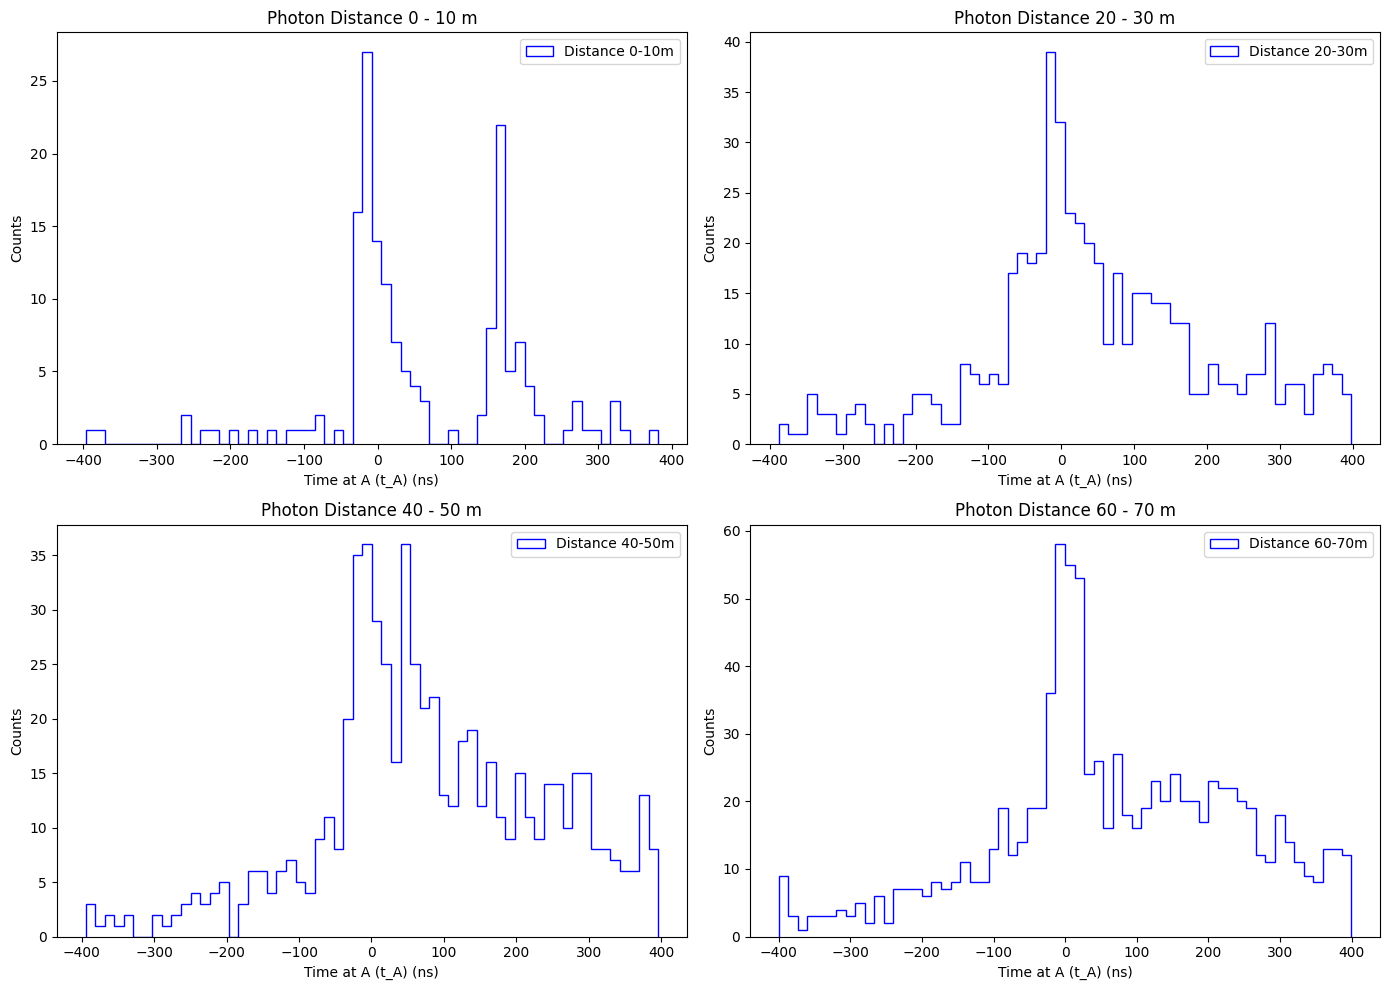

Number of d_Cher_DOMi values between 0 and 10 meters: 189
Number of d_Cher_DOMi values between 10 and 20 meters: 510


In [164]:
bins = [(0, 10), (20, 30), (40, 50), (60, 70)]  # Define distance bins
t_A, photon_dist, _, event_IDs = calculate_ta_for_events(grouped_by_event, Muon_start_pos, theta_c, time_event, min_pulses=15, window_ns=800)
plot_tA_by_distance_bins(t_A, photon_dist, event_IDs, bins)
print(f"Number of d_Cher_DOMi values between 0 and 10 meters: {np.sum((d_Cher_DOMi >= 0) & (d_Cher_DOMi < 10))}")
print(f"Number of d_Cher_DOMi values between 10 and 20 meters: {np.sum((d_Cher_DOMi >= 10) & (d_Cher_DOMi < 20))}")

Number of t_A values smaller than 0: 9374


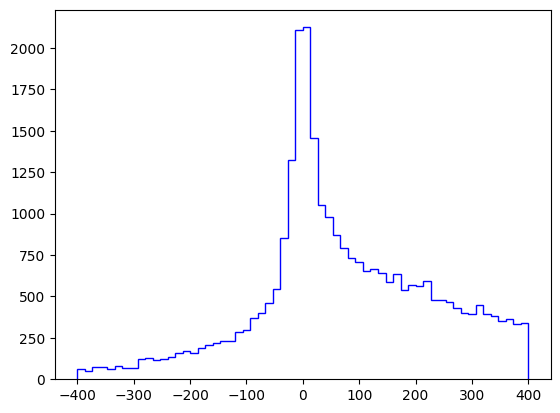

In [165]:
plt.hist(t_A, bins=60, histtype='step', color='blue', label='Shifted t_A')
# Print how many t_A values are smaller than 0
print(f"Number of t_A values smaller than 0: {np.sum(t_A < 0)}")

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms_by_zenith(t_A, muon_zenith_angles, event_ids_expanded, df_secondary, num_bins=9):
    # Convert zenith angles to degrees if they are in radians
    if np.max(muon_zenith_angles) <= np.pi:
        muon_zenith_angles = np.degrees(muon_zenith_angles)
    
    # Drop duplicate and NaN values from df_secondary to map events to zenith angles
    df_secondary_unique = df_secondary.drop_duplicates(subset='EventID').dropna(subset=['Zenith_MuPlus'])
    event_zenith_mapping = dict(zip(df_secondary_unique['EventID'], np.degrees(df_secondary_unique['Zenith_MuPlus'])))

    # Map each event ID in `event_ids_expanded` to its corresponding zenith angle
    zenith_for_dom_hits = np.array([event_zenith_mapping.get(event_id, np.nan) for event_id in event_ids_expanded])

    # Filter out any NaN values that might have come from unmapped event IDs
    valid_mask = ~np.isnan(zenith_for_dom_hits)
    t_A = t_A[valid_mask]
    zenith_for_dom_hits = zenith_for_dom_hits[valid_mask]
    event_ids_expanded = event_ids_expanded[valid_mask]

    # Define zenith angle bins (0 to 180 degrees) and prepare the subplots
    bin_edges = np.linspace(0, 180, num_bins + 1)
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    axes = axes.flatten()

    total_dom_hits = []
    total_unique_events_per_bin = []

    # Loop through each zenith angle bin and plot the histogram
    for i in range(num_bins):
        # Mask for events within the current zenith bin
        bin_mask = (zenith_for_dom_hits >= bin_edges[i]) & (zenith_for_dom_hits < bin_edges[i + 1])
        
        # Extract t_A values and unique event IDs for the current bin
        t_A_bin = t_A[bin_mask]
        unique_event_ids = np.unique(event_ids_expanded[bin_mask])

        # Track the total DOM hits and unique events per bin for debugging
        total_dom_hits.append(len(t_A_bin))
        total_unique_events_per_bin.append(len(unique_event_ids))

        print(f"Bin {i} ({bin_edges[i]:.1f}° - {bin_edges[i+1]:.1f}°): {len(t_A_bin)} DOM hits from {len(unique_event_ids)} unique events.")

        # Plot the histogram for the current bin
        ax = axes[i]
        ax.hist(t_A_bin, bins=80, histtype="step", color="blue", label=f'Zenith {bin_edges[i]}-{bin_edges[i+1]}°')
        ax.set_title(f"Zenith {bin_edges[i]:.1f}° - {bin_edges[i+1]:.1f}°")
        ax.set_xlabel("Time at A (t_A) (ns)")
        ax.set_ylabel("Counts")
        ax.legend()

    print(f"Total DOM hits per bin: {total_dom_hits}")
    print(f"Total unique events per bin: {total_unique_events_per_bin}")
    print(f"Total DOM hits: {sum(total_dom_hits)}")
    
    plt.tight_layout()
    plt.show()


In [31]:
# Call the calculate_ta_for_events function
t_A, d_Cher_DOMi, muon_zenith_angles, event_ids_expanded = calculate_ta_for_events(grouped_by_event, Muon_start_pos, theta_c,time_event, min_pulses=11, window_ns=400)
print(f"Number of t_A values smaller than 0: {np.sum(t_A < 0)}")
# Debugging: Print the lengths to ensure everything matches before calling the plotting function
print(f"Final lengths - t_A: {len(t_A)}, Event IDs: {len(event_ids_expanded)}, Zenith Angles: {len(muon_zenith_angles)}")

# Call the function to plot the histograms by zenith angle
plot_histograms_by_zenith(t_A, muon_zenith_angles, event_ids_expanded, df_secondary, num_bins=9)


Number of t_A values smaller than 0: 0
Final lengths - t_A: 43520, Event IDs: 16062, Zenith Angles: 16062


IndexError: boolean index did not match indexed array along dimension 0; dimension is 43520 but corresponding boolean dimension is 16062

In [27]:
# Make a plot showing the distribution of zenith angles
plt.figure(figsize=(10, 6))
plt.hist(np.degrees(muon_zenith_angles), bins=200, histtype='step', color='blue', label='Muon Zenith Angles')    
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Muon Zenith Angles')
print(f"Number of zenith angles: {len(muon_zenith_angles)}")

NameError: name 'muon_zenith_angles' is not defined

<Figure size 1000x600 with 0 Axes>

In [27]:
# Find how many dublicate events are in the data
dublicates = df_secondary[df_secondary.duplicated(subset='EventID')]
print(f"Number of duplicate events in df_secondary: {len(dublicates)}")
#Print the first instance of a duplicate event
#print(dublicates.head(1))
# Print the eventid of the first duplicate event
print(dublicates['EventID'].values[0])

Number of duplicate events in df_secondary: 73
nan


In [28]:
# print the number of events with zenith angles in the range of 20-40
zenith_0_20 = np.sum((np.degrees(muon_zenith_angles) >= 0) & (np.degrees(muon_zenith_angles) <= 20))
print(f"Number of events with zenith angles between 0 and 20 degrees: {zenith_0_20}")
zenith_20_40 = np.sum((np.degrees(muon_zenith_angles) >= 20) & (np.degrees(muon_zenith_angles) <= 40))
print(f"Number of events with zenith angles between 20 and 40 degrees: {zenith_20_40}")
zenth_40_60 = np.sum((np.degrees(muon_zenith_angles) >= 40) & (np.degrees(muon_zenith_angles) <= 60))
print(f"Number of events with zenith angles between 40 and 60 degrees: {zenth_40_60}")
zenith_60_80 = np.sum((np.degrees(muon_zenith_angles) >= 60) & (np.degrees(muon_zenith_angles) <= 80))
print(f"Number of events with zenith angles between 60 and 80 degrees: {zenith_60_80}")
zenith_80_100 = np.sum((np.degrees(muon_zenith_angles) >= 80) & (np.degrees(muon_zenith_angles) <= 100))

print(f"Number of events with zenith angles between 80 and 100 degrees: {zenith_80_100}")
zenith_100_120 = np.sum((np.degrees(muon_zenith_angles) >= 100) & (np.degrees(muon_zenith_angles) <= 120))
print(f"Number of events with zenith angles between 100 and 120 degrees: {zenith_100_120}")
zenith_120_140 = np.sum((np.degrees(muon_zenith_angles) >= 120) & (np.degrees(muon_zenith_angles) <= 140))
print(f"Number of events with zenith angles between 120 and 140 degrees: {zenith_120_140}")
zenith_140_160 = np.sum((np.degrees(muon_zenith_angles) >= 140) & (np.degrees(muon_zenith_angles) <= 160))
print(f"Number of events with zenith angles between 140 and 160 degrees: {zenith_140_160}")
zenith_160_180 = np.sum((np.degrees(muon_zenith_angles) >= 160) & (np.degrees(muon_zenith_angles) <= 180))
print(f"Number of events with zenith angles between 160 and 180 degrees: {zenith_160_180}")
zenith_total = np.sum((np.degrees(muon_zenith_angles) >= 0) & (np.degrees(muon_zenith_angles) <= 180))
print(f"Total number of events: {zenith_total}")

Number of events with zenith angles between 0 and 20 degrees: 266
Number of events with zenith angles between 20 and 40 degrees: 1267
Number of events with zenith angles between 40 and 60 degrees: 2051
Number of events with zenith angles between 60 and 80 degrees: 2974
Number of events with zenith angles between 80 and 100 degrees: 2914
Number of events with zenith angles between 100 and 120 degrees: 2652
Number of events with zenith angles between 120 and 140 degrees: 1713
Number of events with zenith angles between 140 and 160 degrees: 1631
Number of events with zenith angles between 160 and 180 degrees: 513
Total number of events: 15981
